# Importación de librerias

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer


In [2]:
print("Versión pandas",pd.__version__)
print("Version seaborn", sns.__version__)
!python --version

Versión pandas 2.0.2
Version seaborn 0.12.2
Python 3.11.3


# Cargar datos

In [3]:
CWD_1 = os.getcwd()
DATA_PATH_1 = os.path.join(CWD_1,"data")
FILE_NAME_1 = "2017_lloguer_preu_trim.csv"
lloguer = os.path.join(DATA_PATH_1,FILE_NAME_1)

In [4]:
CWD_2 = os.getcwd()
DATA_PATH_2 = os.path.join(CWD_2,"data")
FILE_NAME_2 = "2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv"
poblacio_soroll = os.path.join(DATA_PATH_2,FILE_NAME_2)

In [5]:
df_lloguer = pd.read_csv(lloguer)
df_poblacio = pd.read_csv(poblacio_soroll)

# Funciones

In [6]:
# Creamos una función simple para hacer un report simple sobre los DataFrame suministrados
def report_df(dataframe, verbose = True):
    print("El tamaño del dataset es", dataframe.shape[0], "filas y", dataframe.shape[1], "columnas")
    print()
    print(dataframe.info(verbose = verbose))
    total_nulos = dataframe.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")
    print()
    print("Hay", dataframe.duplicated().sum(), "duplicados")


In [7]:
# Función para convertir columnas categóricas a numéricas de cara a preprocesar los datos y preparlos para un modelo
def OHE (dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name],prefix=column_name)
    dataframe = pd.concat([dataframe,_dummy_dataset],axis=1)
    return dataframe.drop(column_name,axis=1)

In [8]:
# Función para reducir la dimensionalidad de variables que contengan etiquetas similares
def juntar_etiquetas(dataframe,column,value_contain,new_value):
    dataframe.loc[dataframe[column].str.contains(value_contain), column] = new_value

# df_lloguer -- análisis y limpieza

In [9]:
report_df(df_lloguer)

df_lloguer.head(2)

El tamaño del dataset es 584 filas y 8 columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Any             584 non-null    int64  
 1   Trimestre       584 non-null    int64  
 2   Codi_Districte  584 non-null    int64  
 3   Nom_Districte   584 non-null    object 
 4   Codi_Barri      584 non-null    int64  
 5   Nom_Barri       584 non-null    object 
 6   Lloguer_mitja   584 non-null    object 
 7   Preu            546 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 36.6+ KB
None

Tenemos un total de 38 nulos

Hay 0 duplicados


,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,2017,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
1,2017,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26


In [10]:
df_lloguer.isnull().sum()

Any                0
Trimestre          0
Codi_Districte     0
Nom_Districte      0
Codi_Barri         0
Nom_Barri          0
Lloguer_mitja      0
Preu              38
dtype: int64

In [11]:
df_lloguer[df_lloguer['Preu'].isnull()]

,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
11,2017,1,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN
41,2017,1,7,Horta-Guinardó,42,la Clota,Lloguer mitjà mensual (Euros/mes),NaN
46,2017,1,8,Nou Barris,47,Can Peguera,Lloguer mitjà mensual (Euros/mes),NaN
55,2017,1,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),NaN
57,2017,1,9,Sant Andreu,58,Baró de Viver,Lloguer mitjà mensual (Euros/mes),NaN
84,2017,2,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN
114,2017,2,7,Horta-Guinardó,42,la Clota,Lloguer mitjà mensual (Euros/mes),NaN
126,2017,2,8,Nou Barris,54,Torre Baró,Lloguer mitjà mensual (Euros/mes),NaN
130,2017,2,9,Sant Andreu,58,Baró de Viver,Lloguer mitjà mensual (Euros/mes),NaN
157,2017,3,3,Sants-Montjuïc,12,la Marina del Prat Vermell,Lloguer mitjà mensual (Euros/mes),NaN


In [12]:
df_lloguer[df_lloguer['Preu'].isnull()]['Nom_Barri'].unique()   
#Vemos en que barrios tenemos los nulos para buscar algún patron y decidir como imputarlos mejor

array(['la Marina del Prat Vermell', 'la Clota', 'Can Peguera',
       'Vallbona', 'Baró de Viver', 'Torre Baró'], dtype=object)

In [13]:
df_lloguer[df_lloguer['Nom_Barri']=='Vallbona']
#Análizamos un barrio con valores nulos al azar

,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
55,2017,1,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),NaN
128,2017,2,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),302.52
201,2017,3,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),NaN
274,2017,4,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),NaN
347,2017,1,8,Nou Barris,56,Vallbona,Lloguer mitjà per superfície (Euros/m2 mes),NaN
420,2017,2,8,Nou Barris,56,Vallbona,Lloguer mitjà per superfície (Euros/m2 mes),4.45
493,2017,3,8,Nou Barris,56,Vallbona,Lloguer mitjà per superfície (Euros/m2 mes),NaN
566,2017,4,8,Nou Barris,56,Vallbona,Lloguer mitjà per superfície (Euros/m2 mes),NaN


In [14]:
df_lloguer[df_lloguer['Nom_Districte']=='Sants-Montjuïc']['Codi_Barri'].unique()
# Observamos como se compone cada distrito, no depende de un único barrio, sino que puede contener varios

array([11, 12, 13, 14, 15, 16, 17, 18], dtype=int64)

In [15]:
df_lloguer.describe(include=np.number).T   #Realizamos un describe de variables numéricas para ver su distribución

,count,mean,std,min,25%,50%,75%,max
Any,584.0,2017.000000,0.000000,2017.00,2017.000,2017.000,2017.0000,2017.00
Trimestre,584.0,2.500000,1.118992,1.00,1.750,2.500,3.2500,4.00
Codi_Districte,584.0,6.246575,2.790726,1.00,4.000,7.000,8.0000,10.00
Codi_Barri,584.0,37.000000,21.089371,1.00,19.000,37.000,55.0000,73.00
Preu,546.0,421.009231,446.178147,4.45,12.645,161.565,770.3475,1882.42


In [16]:
df_lloguer.describe(exclude=np.number).T   #Realizamos un describe de variables categóricas para ver su distribución

,count,unique,top,freq
Nom_Districte,584,10,Nou Barris,104
Nom_Barri,584,73,el Raval,8
Lloguer_mitja,584,2,Lloguer mitjà mensual (Euros/mes),292


In [17]:
df_lloguer['Lloguer_mitja'].value_counts()

Lloguer_mitja
Lloguer mitjà mensual (Euros/mes)              292
Lloguer mitjà per superfície (Euros/m2 mes)    292
Name: count, dtype: int64

#### Observamos que tenemos un Datset de 10 Distritos distintos y con 73 Barrios, como hemos comprobado antes, cada Distrito esta compuesto de varios Barrios. De ahí que obtengamos un Dataset de 292 filas. Si comprobamos además el patrón de Lloguer_mitja podemos intuir que puede dividirse en 2. Por un lado Precio medio mensual para cada barrio y distrito, de ahí las 292 filas y por otro lado el precio medio por m2 por barrio y distrito de ahí las otras 292 filas. En total conforman nuestro dataset de 584 filas. Veremos más adelante como tratamos esto.

#### También vemos que hay columnas sin varianza como el caso del año,siempre es 2017, por lo tanto no nos aporta información útil de cara a hacer un futuro modelo y por eso lo eliminamos utilizando esta función lambda.

In [18]:
list_vars_non_variance = [column for column in df_lloguer.columns if df_lloguer[column].nunique(dropna = False) == 1]
df_lloguer.drop(list_vars_non_variance, axis = 1, inplace = True)

In [19]:
df_lloguer.head(1)

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99


In [20]:
df_lloguer[df_lloguer['Lloguer_mitja']=="Lloguer mitjà mensual (Euros/mes)"]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
1,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26
2,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà mensual (Euros/mes),722.78
3,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà mensual (Euros/mes),895.28
4,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà mensual (Euros/mes),871.08
...,...,...,...,...,...,...,...
287,4,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,Lloguer mitjà mensual (Euros/mes),1233.01
288,4,10,Sant Martí,70,el Besòs i el Maresme,Lloguer mitjà mensual (Euros/mes),621.32
289,4,10,Sant Martí,71,Provençals del Poblenou,Lloguer mitjà mensual (Euros/mes),864.09
290,4,10,Sant Martí,72,Sant Martí de Provençals,Lloguer mitjà mensual (Euros/mes),790.58


In [21]:
df_lloguer[df_lloguer['Lloguer_mitja']!="Lloguer mitjà mensual (Euros/mes)"]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
292,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),13.50
293,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà per superfície (Euros/m2 mes),14.14
294,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà per superfície (Euros/m2 mes),19.46
295,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà per superfície (Euros/m2 mes),15.01
296,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà per superfície (Euros/m2 mes),12.77
...,...,...,...,...,...,...,...
579,4,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,Lloguer mitjà per superfície (Euros/m2 mes),16.51
580,4,10,Sant Martí,70,el Besòs i el Maresme,Lloguer mitjà per superfície (Euros/m2 mes),10.40
581,4,10,Sant Martí,71,Provençals del Poblenou,Lloguer mitjà per superfície (Euros/m2 mes),12.66
582,4,10,Sant Martí,72,Sant Martí de Provençals,Lloguer mitjà per superfície (Euros/m2 mes),10.83


In [22]:
df_lloguer[(df_lloguer['Codi_Barri']==1)&(df_lloguer['Codi_Districte']==1)]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
73,2,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),714.29
146,3,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),764.85
219,4,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),776.73
292,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),13.50
365,2,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),13.69
438,3,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),13.97
511,4,1,Ciutat Vella,1,el Raval,Lloguer mitjà per superfície (Euros/m2 mes),14.42


#### Hemos visto que el DataFrame de lloguer esta compuesto por 584 filas, 292 con precio medio mensual del alquiler y los otros 292 son exactamente las mismas filas varian que el precio esta puesto por m2. Así que vamos a generar un "id" único para cada fila, ya que cada fila corresponde a un trimestre, distrito y barrio distintos. 

#### Después colocaremos esas 292 filas con precio por m2 y lo convertiremos en una columna, de tal manera que nos quedaremos con un Dataframe de lloguer de 292 filas y con valores de precio medio mensual y precio por m2 en columnas diferenciadas

In [23]:
# Creación de id único con Trimestre, Distrito y Barrio
df_lloguer['id'] = df_lloguer['Trimestre'].apply(str) + "_" + df_lloguer['Codi_Districte'].apply(str)  + "_" + df_lloguer['Codi_Barri'].apply(str) 

In [24]:
df_lloguer.set_index('id',inplace=True)

In [25]:
# Filtramos por los valores de precio medio por superficie y nos quedamos con el precio, 
# le cambiamos el nombre a la columna para después poder hacer merge con la otra parte del df y tenerlo bien identificado.
preu_superficie = df_lloguer[df_lloguer['Lloguer_mitja']=="Lloguer mitjà per superfície (Euros/m2 mes)"][['Preu']]
preu_superficie.rename(columns = {"Preu":"Preu_lloguer_mitja_superficie_m2"},inplace=True)

In [26]:
preu_superficie #imprimimos para ver cómo queda

,Preu_lloguer_mitja_superficie_m2
id,
1_1_1,13.50
1_1_2,14.14
1_1_3,19.46
1_1_4,15.01
1_2_5,12.77
...,...
4_10_69,16.51
4_10_70,10.40
4_10_71,12.66


In [27]:
# Filtramos por la otra mitad del dataset y cambiamos también el nombre de la columna para tenerlo bien identificado
df_lloguer_unique = df_lloguer[df_lloguer['Lloguer_mitja']=="Lloguer mitjà mensual (Euros/mes)"]
df_lloguer_unique.rename(columns = {"Preu":"Preu_lloguer_mitja_mensual"},inplace=True)

In [28]:
# Hacemos merge a través del 'id' que hemos creado antes e imprimimos el shape antes y después para asegurar de no hacer un cartesiano
print(df_lloguer_unique.shape)

df_lloguer_unique = pd.merge(df_lloguer_unique,preu_superficie, on = 'id', how='left')

print(df_lloguer_unique.shape)

(292, 7)
(292, 8)


In [29]:
df_lloguer_unique.isnull().sum() #comprobamos los nulos y vemos que coinciden con los que teniamos desde un inicio

Trimestre                            0
Codi_Districte                       0
Nom_Districte                        0
Codi_Barri                           0
Nom_Barri                            0
Lloguer_mitja                        0
Preu_lloguer_mitja_mensual          19
Preu_lloguer_mitja_superficie_m2    19
dtype: int64

#### Realizamos una comprobación visual para ver que coincide el cambio realizado

In [30]:
df_lloguer_unique[(df_lloguer_unique['Codi_Barri']==1)&(df_lloguer_unique['Codi_Districte']==1)]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie_m2
id,,,,,,,,
1_1_1,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99,13.50
2_1_1,2,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),714.29,13.69
3_1_1,3,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),764.85,13.97
4_1_1,4,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),776.73,14.42


# Análisis visual de variables

#### Ahora que ya tenemos el Dataset "mejor ordenado", vamos a realizar comprobaciones visuales para ver como se distribuyen, poder capturar la existencia de outliers, etc

<Axes: >

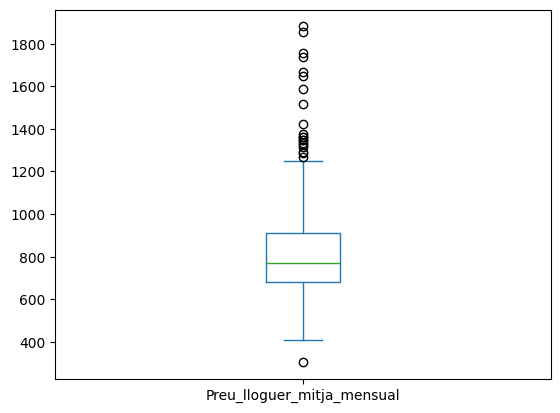

In [31]:
df_lloguer_unique['Preu_lloguer_mitja_mensual'].plot(kind="box")

In [32]:
df_lloguer_unique[df_lloguer_unique['Preu_lloguer_mitja_mensual']<=400]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie_m2
id,,,,,,,,
2_8_56,2,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),302.52,4.45


In [33]:
df_lloguer_unique[df_lloguer_unique['Nom_Barri']=="Vallbona"]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie_m2
id,,,,,,,,
1_8_56,1,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),NaN,NaN
2_8_56,2,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),302.52,4.45
3_8_56,3,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),NaN,NaN
4_8_56,4,8,Nou Barris,56,Vallbona,Lloguer mitjà mensual (Euros/mes),NaN,NaN


In [34]:
df_lloguer_unique[df_lloguer_unique['Preu_lloguer_mitja_mensual']>=1400]

,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie_m2
id,,,,,,,,
1_4_21,1,4,Les Corts,21,Pedralbes,Lloguer mitjà mensual (Euros/mes),1856.57,16.05
1_5_24,1,5,Sarrià-Sant Gervasi,24,les Tres Torres,Lloguer mitjà mensual (Euros/mes),1516.52,16.12
2_4_21,2,4,Les Corts,21,Pedralbes,Lloguer mitjà mensual (Euros/mes),1666.63,16.76
2_5_23,2,5,Sarrià-Sant Gervasi,23,Sarrià,Lloguer mitjà mensual (Euros/mes),1423.86,17.93
2_5_24,2,5,Sarrià-Sant Gervasi,24,les Tres Torres,Lloguer mitjà mensual (Euros/mes),1646.76,16.76
3_4_21,3,4,Les Corts,21,Pedralbes,Lloguer mitjà mensual (Euros/mes),1882.42,16.54
3_5_24,3,5,Sarrià-Sant Gervasi,24,les Tres Torres,Lloguer mitjà mensual (Euros/mes),1757.00,16.07
4_4_21,4,4,Les Corts,21,Pedralbes,Lloguer mitjà mensual (Euros/mes),1737.92,15.22
4_5_24,4,5,Sarrià-Sant Gervasi,24,les Tres Torres,Lloguer mitjà mensual (Euros/mes),1588.53,18.38


<Axes: >

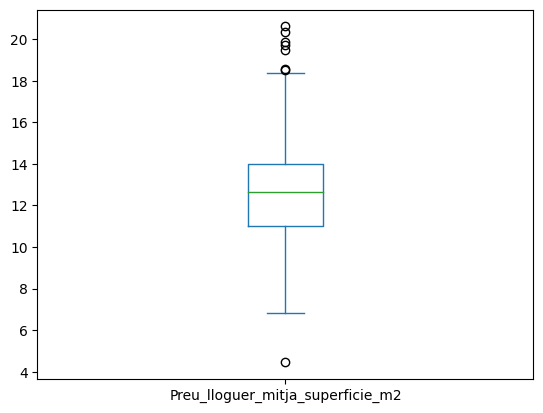

In [35]:
df_lloguer_unique['Preu_lloguer_mitja_superficie_m2'].plot(kind="box")

#### Comprobamos que tanto los valores por encima y por debajo que están fuera de rango intercuartiles, no los consideraremos outliers, ya que tiene sentido que el barrio de Sarria , Pedralbes y les Tres Torres , son considerados de las rentas per cápita más elevadas de Cataluña. Y por otro lado, Vallbona, es uno de los barrios más baratos.

#### En el ranking del Precio Medio del Alquiler en Barcelona, el barrio Vallbona ocupa el puesto 0 de los 75 barrios de toda la ciudad. Titular sacado de: https://www.enalquiler.com/barrios/barcelona/vallbona_50.html

In [36]:
df_lloguer_unique.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
Trimestre,292.0,2.500000,1.119953,1.00,1.75,2.50,3.25,4.00
Codi_Districte,292.0,6.246575,2.793123,1.00,4.00,7.00,8.00,10.00
Codi_Barri,292.0,37.000000,21.107481,1.00,19.00,37.00,55.00,73.00
Preu_lloguer_mitja_mensual,273.0,829.380403,253.210128,302.52,680.80,771.78,912.51,1882.42
Preu_lloguer_mitja_superficie_m2,273.0,12.638059,2.479090,4.45,11.00,12.64,13.97,20.61


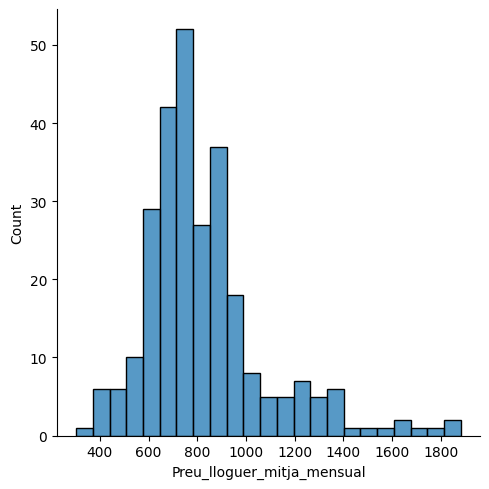

In [37]:
sns.displot(df_lloguer_unique['Preu_lloguer_mitja_mensual']);  
#Podemos obrservar como la mayoría de precio oscila entre 600€ y 1000€ aprox (€/mes)

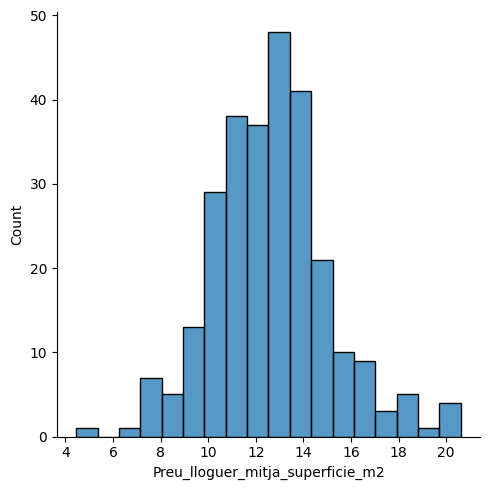

In [38]:
sns.displot(df_lloguer_unique['Preu_lloguer_mitja_superficie_m2']);   
#Podemos obrservar como la mayoría de precio oscila entre 10€ y 15€ aprox ( €/m2)

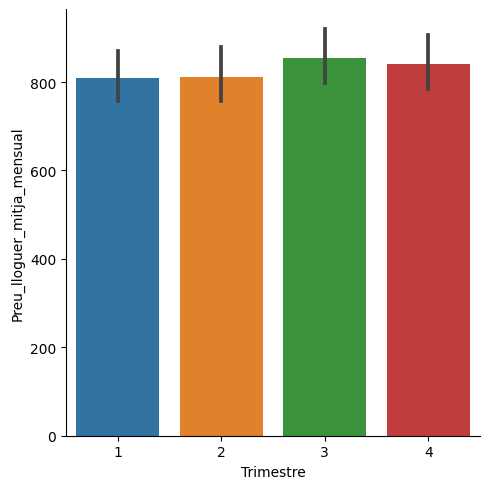

In [39]:
sns.catplot(df_lloguer_unique,x = 'Trimestre',y = 'Preu_lloguer_mitja_mensual',kind = 'bar'); 
#Observamos que el 3 trimestre es donde se registran la media de precios más elevada

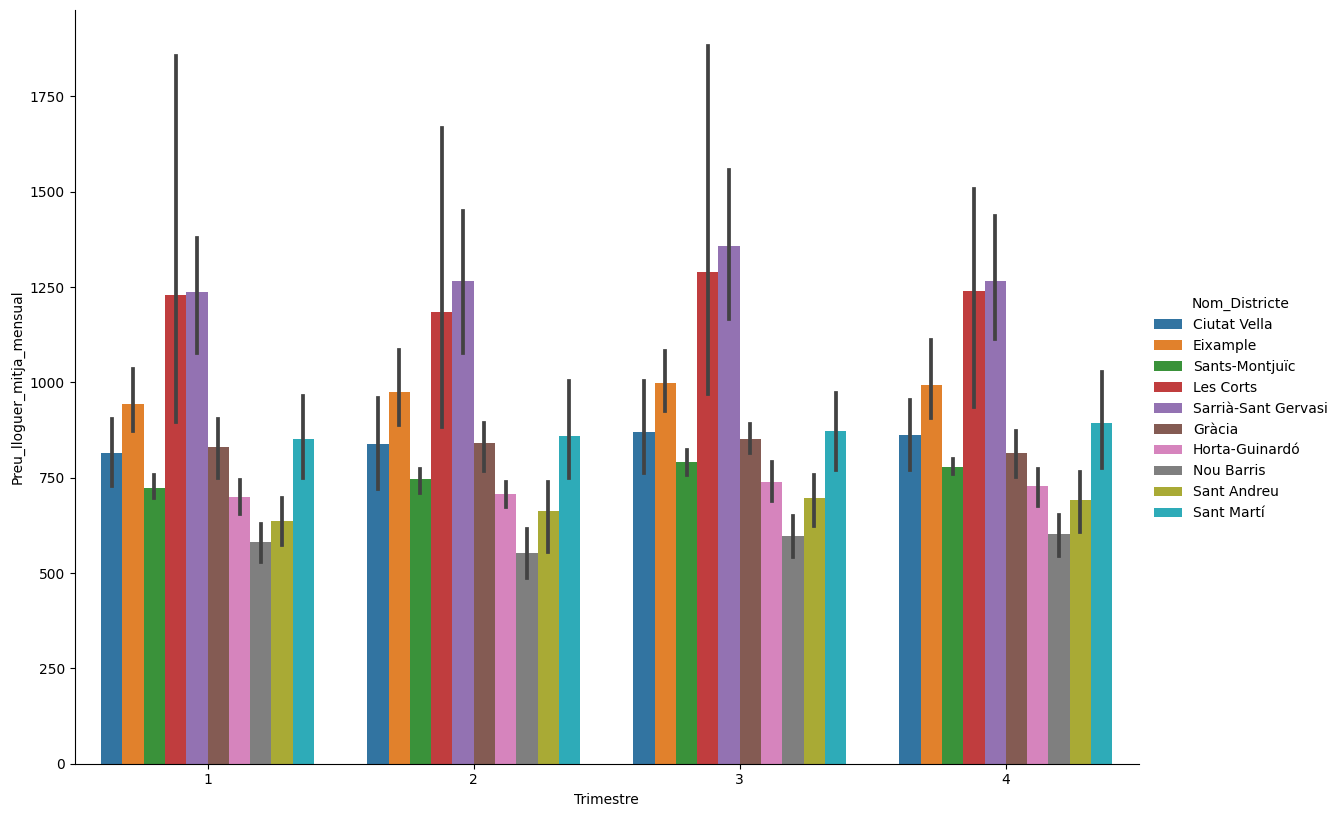

In [40]:
sns.catplot(df_lloguer_unique,x = 'Trimestre',y = 'Preu_lloguer_mitja_mensual',hue = "Nom_Districte",kind = 'bar',height=8.27, aspect=11.7/8.27); 

In [41]:
# Observamos como en todos los trimestres Sarrià-Sant Gervasiy Les Corts son los dos distritos con los precios más altos, respectivamente.
# Por contra, Nou Barris y Sant Andreu los distritos más baratos, respectivamente.

# Imputación de valores nulos en precio

#### La primera opción es buscar en alguna otra base de datos si podemos saber los valores nulos de alguna manera.

#### Hemos buscado en: 
https://ajuntament.barcelona.cat/estadistica/catala/Estadistiques_per_temes/Habitatge_i_mercat_immobiliari/Mercat_immobiliari/Habitatges_lloguer/index.htm  
#### y no hemos podido sacar estos valore nulos, ya que justamente tenemos los mismos datos.

#### Siguiente opción sería imputar con el KNNImputer, los valores más cercanos. Aunque primero realizaremos un groupby por barrio y realizaremos un bcfill, fffill, por si alguno de ellos tuviese algun valor en un determinado trimestre, como el ejemplo de "VALLBONA", donde nos interesa más que nos impute su mismo valor que el valor de otro barrio. Para el resto en el que el valor sea todo nulo, el KNN buscará por cercania los valores que correspondan y los imputará

In [42]:
df_lloguer_unique['Preu_lloguer_mitja_mensual'] = df_lloguer_unique.groupby(['Nom_Barri'], group_keys=False)['Preu_lloguer_mitja_mensual'].apply(
    lambda series: series.bfill().ffill()
)
df_lloguer_unique['Preu_lloguer_mitja_superficie_m2'] = df_lloguer_unique.groupby(['Nom_Barri'], group_keys = False)['Preu_lloguer_mitja_superficie_m2'].apply(
    lambda series: series.bfill().ffill()
)

In [43]:
df_lloguer_unique.isnull().sum() #Comprobamos nulos despuéss del cambio

Trimestre                            0
Codi_Districte                       0
Nom_Districte                        0
Codi_Barri                           0
Nom_Barri                            0
Lloguer_mitja                        0
Preu_lloguer_mitja_mensual          12
Preu_lloguer_mitja_superficie_m2    12
dtype: int64

#### Observamos como 7 valores nulos han sido imputados, queire decir que teniamos barrios con algún valor y el resto nulos, al hacer esta imputación nos aseguramos de que ese barrio tenga un precio similar a si mismo y no a otro.

#### Ahora usaremos el KNNImputer para imputar el resto de precios en función de sus vecinos más cercanos, de esta manera podemos imputar nulos y el agoritmo buscará aquellos más parecidos (barrio, distrito,etc), para imputar valores 

In [44]:
imputer = KNNImputer()  #Instanciamos el KNNImputer

In [45]:
df_lloguer_unique.describe(include = np.number).columns

Index(['Trimestre', 'Codi_Districte', 'Codi_Barri',
       'Preu_lloguer_mitja_mensual', 'Preu_lloguer_mitja_superficie_m2'],
      dtype='object')

In [46]:
df_lloguer_unique_num = df_lloguer_unique[
    ['Trimestre', 
     'Codi_Districte', 
     'Codi_Barri',
     'Preu_lloguer_mitja_mensual', 
     'Preu_lloguer_mitja_superficie_m2']]

# Aprovechando que los barrios y distritos tienen su variable ya numérica, 
# no nos hace falta hacer ningún tipo de imputación, simplemente seleccionamos las variables numéricas 
# del dataset para pasárselo al KNNImputer y que pueda imputar los valores nulos

In [47]:
df_lloguer_unique_num = imputer.fit_transform(df_lloguer_unique_num) #Entrenamos modelo de imputación y transformamos los nulos

In [48]:
df_lloguer_unique_num.isnull().sum() #Ya hemos imputado los valores nulos

Trimestre                           0
Codi_Districte                      0
Codi_Barri                          0
Preu_lloguer_mitja_mensual          0
Preu_lloguer_mitja_superficie_m2    0
dtype: int64

#### Vamos a concatenar las otras columnas que no hemos seleccionado antes para poder concatenar con el df_poblacio

#### Como no hemos alterado el orden del dataset podemos hacer un concat en axis=1, podemos estar seguros de que seguirá el mismo orden que debería

In [49]:
df_lloguer_unique_clean = pd.concat([df_lloguer_unique_num,df_lloguer_unique[['Nom_Districte','Nom_Barri']]],axis=1)

In [50]:
df_lloguer_unique_clean #Imprimimos por pantalla para ver como queda

,Trimestre,Codi_Districte,Codi_Barri,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie_m2,Nom_Districte,Nom_Barri
id,,,,,,,
1_1_1,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval
1_1_2,1.0,1.0,2.0,905.26,14.14,Ciutat Vella,el Barri Gòtic
1_1_3,1.0,1.0,3.0,722.78,19.46,Ciutat Vella,la Barceloneta
1_1_4,1.0,1.0,4.0,895.28,15.01,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera"
1_2_5,1.0,2.0,5.0,871.08,12.77,Eixample,el Fort Pienc
...,...,...,...,...,...,...,...
4_10_69,4.0,10.0,69.0,1233.01,16.51,Sant Martí,Diagonal Mar i el Front Marítim del Poblenou
4_10_70,4.0,10.0,70.0,621.32,10.40,Sant Martí,el Besòs i el Maresme
4_10_71,4.0,10.0,71.0,864.09,12.66,Sant Martí,Provençals del Poblenou


#### Pequeña comprobación de como se han imputado los valores nulos

In [51]:
df_lloguer_unique_clean[df_lloguer_unique_clean['Nom_Barri']=="Vallbona"]

,Trimestre,Codi_Districte,Codi_Barri,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie_m2,Nom_Districte,Nom_Barri
id,,,,,,,
1_8_56,1.0,8.0,56.0,302.52,4.45,Nou Barris,Vallbona
2_8_56,2.0,8.0,56.0,302.52,4.45,Nou Barris,Vallbona
3_8_56,3.0,8.0,56.0,302.52,4.45,Nou Barris,Vallbona
4_8_56,4.0,8.0,56.0,302.52,4.45,Nou Barris,Vallbona


In [52]:
df_lloguer_unique_clean[df_lloguer_unique_clean['Nom_Barri']=='Torre Baró']

,Trimestre,Codi_Districte,Codi_Barri,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie_m2,Nom_Districte,Nom_Barri
id,,,,,,,
1_8_54,1.0,8.0,54.0,418.07,7.26,Nou Barris,Torre Baró
2_8_54,2.0,8.0,54.0,463.17,6.84,Nou Barris,Torre Baró
3_8_54,3.0,8.0,54.0,463.17,6.84,Nou Barris,Torre Baró
4_8_54,4.0,8.0,54.0,448.23,7.17,Nou Barris,Torre Baró


In [56]:
df_lloguer_unique_clean["m2_superficie_media"] = df_lloguer_unique_clean['Preu_lloguer_mitja_mensual']/df_lloguer_unique_clean['Preu_lloguer_mitja_superficie_m2']

In [62]:
# Sacamos una variable nueva de dividir el precio medio mensual por el precio por m2 y conseguimos saber la superficie media en m2 de las viviendas

# df_poblacio -- análisis y limpieza

In [63]:
report_df(df_poblacio)

df_poblacio.head(2)

El tamaño del dataset es 18980 filas y 7 columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18980 entries, 0 to 18979
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Codi_Districte  18980 non-null  int64 
 1   Nom_Districte   18980 non-null  object
 2   Codi_Barri      18980 non-null  int64 
 3   Nom_Barri       18980 non-null  object
 4   Concepte        18980 non-null  object
 5   Rang_soroll     18980 non-null  object
 6   Valor           18980 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.0+ MB
None

Tenemos un total de 0 nulos

Hay 0 duplicados


,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73%
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98%


##### De primeras vemos Rang_soroll y Valor son object y debrían ser int o float. Seguramente debido a los símbolos que contienen de < = %, etc.

In [64]:
df_poblacio.describe(include = np.number).T   #Realizamos un describe de variables numéricas para ver su distribución

,count,mean,std,min,25%,50%,75%,max
Codi_Districte,18980.0,6.246575,2.788409,1.0,4.0,7.0,8.0,10.0
Codi_Barri,18980.0,37.000000,21.071863,1.0,19.0,37.0,55.0,73.0


In [65]:
df_poblacio.describe(exclude=np.number).T   #Realizamos un describe de variables categóricas para ver su distribución

,count,unique,top,freq
Nom_Districte,18980,10,Nou Barris,3380
Nom_Barri,18980,73,el Raval,260
Concepte,18980,26,TOTAL_D,730
Rang_soroll,18980,10,<40 dB,1898
Valor,18980,3104,0.00%,9953


In [66]:
df_poblacio[(df_poblacio['Codi_Districte']==1) & (df_poblacio['Codi_Barri']==1)] #Observamos de manera específica el dataset

,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73%
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98%
2,1,Ciutat Vella,1,el Raval,TOTAL_D,45-50 dB,7.38%
3,1,Ciutat Vella,1,el Raval,TOTAL_D,50-55 dB,11.97%
4,1,Ciutat Vella,1,el Raval,TOTAL_D,55-60 dB,19.85%
...,...,...,...,...,...,...,...
18255,1,Ciutat Vella,1,el Raval,PARCS_D,60-65 dB,0.00%
18256,1,Ciutat Vella,1,el Raval,PARCS_D,65-70 dB,0.00%
18257,1,Ciutat Vella,1,el Raval,PARCS_D,70-75 dB,0.00%
18258,1,Ciutat Vella,1,el Raval,PARCS_D,75-80 dB,0.00%


In [67]:
df_poblacio['Concepte'].unique() 
#Juntaremos etiquetas y haremos menos grupos en Conceptos, ya que muchos forman parte de grupos similares

array(['TOTAL_D', 'TOTAL_E', 'TOTAL_N', 'TOTAL_DEN', 'TRANSIT_D',
       'TRANSIT_E', 'TRANSIT_N', 'TRANSIT_DEN', 'GI_TR_D', 'GI_TR_E',
       'GI_TR_N', 'GI_TR_DEN', 'FFCC_D', 'FFCC_E', 'FFCC_N', 'FFCC_DEN',
       'INDUST_D', 'INDUST_E', 'INDUST_N', 'INDUST_DEN', 'VIANANTS_D',
       'VIANANTS_E', 'OCI_N', 'PATIS_D', 'PATIS_E', 'PARCS_D'],
      dtype=object)

##### Clasifficación general de Concepte, según la web de www.barcelona.cat, lo divide en estas 9 categorias diferentes:

###### TOTAL
###### PATIS
######  OCI
######  VIANANTS
######  INDUST
######  FFCC
######  GI
######  TRANSIT
######  PARCS

In [68]:
df_poblacio.columns

Index(['Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri',
       'Concepte', 'Rang_soroll', 'Valor'],
      dtype='object')

In [69]:
# agrupación de etiquetas con la función definida arriba

juntar_etiquetas(df_poblacio, 'Concepte', 'TOTAL', 'TOTAL')
juntar_etiquetas(df_poblacio, 'Concepte', 'TRANSIT', 'TRANSIT')
juntar_etiquetas(df_poblacio, 'Concepte', 'GI_TR', 'GI_TR')
juntar_etiquetas(df_poblacio, 'Concepte', 'FFCC', 'FFCC')
juntar_etiquetas(df_poblacio, 'Concepte', 'INDUST', 'INDUST')
juntar_etiquetas(df_poblacio, 'Concepte', 'VIANANTS', 'VIANANTS')
juntar_etiquetas(df_poblacio, 'Concepte', 'OCI', 'OCI')
juntar_etiquetas(df_poblacio, 'Concepte', 'PATIS', 'PATIS')
juntar_etiquetas(df_poblacio, 'Concepte', 'PARCS', 'PARCS')

In [70]:
df_poblacio['Concepte'].value_counts()  #Comprobación de la agrupación

Concepte
TOTAL       2920
TRANSIT     2920
GI_TR       2920
FFCC        2920
INDUST      2920
VIANANTS    1460
PATIS       1460
OCI          730
PARCS        730
Name: count, dtype: int64

In [71]:
# Para convertir esta columna a numérica, separaremos el número del símbolo y nos quedaremos únicamente con el número
df_poblacio['Valor'] = df_poblacio['Valor'].str.split("%",expand=True)[[0]]  #Seleccionamos únicamente el número
df_poblacio.rename(columns = {'Valor':'Valor_porcentaje'},inplace=True) #Renombramos columna para saber que el valor esta en % aunque no tengamos símbolo

In [72]:
df_poblacio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18980 entries, 0 to 18979
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Codi_Districte    18980 non-null  int64 
 1   Nom_Districte     18980 non-null  object
 2   Codi_Barri        18980 non-null  int64 
 3   Nom_Barri         18980 non-null  object
 4   Concepte          18980 non-null  object
 5   Rang_soroll       18980 non-null  object
 6   Valor_porcentaje  18980 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.0+ MB


In [73]:
df_poblacio['Valor_porcentaje'] = df_poblacio['Valor_porcentaje'].astype(float) #Convertimos a numérico los valores

In [74]:
#Creación de id único con Trimestre, Distrito y Barrio
df_poblacio['id'] = df_poblacio['Codi_Districte'].apply(str)  + "_" + df_poblacio['Codi_Barri'].apply(str) + "_" + df_poblacio['Rang_soroll']

df_poblacio.set_index('id',inplace=True)

In [75]:
# Agrupamos por indice y concepto, ya que ahora con la agrupación de etiquetas previa, tenemos filas con etiquetas similares
# y calculamos el valor medio para agrupar en una única celda en vez de en 10
df_poblacio['media_valor_concepte'] = df_poblacio.groupby([df_poblacio.index,'Concepte'])[['Valor_porcentaje']].transform(np.mean)

In [76]:
df_poblacio[df_poblacio['Concepte'] == 'VIANANTS']

,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor_porcentaje,media_valor_concepte
id,,,,,,,,
1_1_<40 dB,1,Ciutat Vella,1,el Raval,VIANANTS,<40 dB,57.69,58.410
1_1_40-45 dB,1,Ciutat Vella,1,el Raval,VIANANTS,40-45 dB,13.35,15.075
1_1_45-50 dB,1,Ciutat Vella,1,el Raval,VIANANTS,45-50 dB,10.90,9.970
1_1_50-55 dB,1,Ciutat Vella,1,el Raval,VIANANTS,50-55 dB,10.81,9.420
1_1_55-60 dB,1,Ciutat Vella,1,el Raval,VIANANTS,55-60 dB,6.47,6.245
...,...,...,...,...,...,...,...,...
10_73_60-65 dB,10,Sant Martí,73,la Verneda i la Pau,VIANANTS,60-65 dB,0.00,0.000
10_73_65-70 dB,10,Sant Martí,73,la Verneda i la Pau,VIANANTS,65-70 dB,0.00,0.000
10_73_70-75 dB,10,Sant Martí,73,la Verneda i la Pau,VIANANTS,70-75 dB,0.00,0.000


In [77]:
# Eliminamos la columna sobre la que hemos realizado el cálculo anterior
df_poblacio.drop('Valor_porcentaje',axis=1,inplace=True)
df_poblacio.reset_index(drop=True,inplace=True)
df_poblacio

,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,media_valor_concepte
0,1,Ciutat Vella,1,el Raval,TOTAL,<40 dB,18.0500
1,1,Ciutat Vella,1,el Raval,TOTAL,40-45 dB,20.2875
2,1,Ciutat Vella,1,el Raval,TOTAL,45-50 dB,8.9775
3,1,Ciutat Vella,1,el Raval,TOTAL,50-55 dB,11.8725
4,1,Ciutat Vella,1,el Raval,TOTAL,55-60 dB,16.3775
...,...,...,...,...,...,...,...
18975,10,Sant Martí,73,la Verneda i la Pau,PARCS,60-65 dB,0.0000
18976,10,Sant Martí,73,la Verneda i la Pau,PARCS,65-70 dB,0.0000
18977,10,Sant Martí,73,la Verneda i la Pau,PARCS,70-75 dB,0.0000
18978,10,Sant Martí,73,la Verneda i la Pau,PARCS,75-80 dB,0.0000


In [78]:
# Hacemos un pivot table para convertir la columna Concepto en columnas según las 9 etiquetas agrupadas 
df_poblacio = pd.pivot_table(df_poblacio,index = ['Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri','Rang_soroll'], columns = 'Concepte',values = "media_valor_concepte")
df_poblacio.reset_index(inplace=True)

In [79]:
df_poblacio[(df_poblacio['Codi_Districte']==1) & (df_poblacio['Codi_Barri']==1)] 
# Comprobamos que dentro de las columnas de concepto nos de el 100% a los largo del rango de ruido como  antes

Concepte,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Rang_soroll,FFCC,GI_TR,INDUST,OCI,PARCS,PATIS,TOTAL,TRANSIT,VIANANTS
0,1,Ciutat Vella,1,el Raval,40-45 dB,0.0,5.3400,0.0,4.97,0.0,0.000,20.2875,23.1625,15.075
1,1,Ciutat Vella,1,el Raval,45-50 dB,0.0,1.7425,0.0,2.53,0.0,0.000,8.9775,9.3350,9.970
2,1,Ciutat Vella,1,el Raval,50-55 dB,0.0,0.8500,0.0,1.80,0.0,0.825,11.8725,12.8425,9.420
3,1,Ciutat Vella,1,el Raval,55-60 dB,0.0,0.6025,0.0,5.79,0.0,1.335,16.3775,15.2550,6.245
4,1,Ciutat Vella,1,el Raval,60-65 dB,0.0,0.7325,0.0,8.88,0.0,0.890,14.8850,10.7925,0.880
5,1,Ciutat Vella,1,el Raval,65-70 dB,0.0,0.6500,0.0,0.14,0.0,0.000,7.4325,5.3225,0.000
6,1,Ciutat Vella,1,el Raval,70-75 dB,0.0,0.6750,0.0,0.00,0.0,0.000,2.0925,1.7300,0.000
7,1,Ciutat Vella,1,el Raval,75-80 dB,0.0,0.0000,0.0,0.00,0.0,0.000,0.0250,0.0250,0.000
8,1,Ciutat Vella,1,el Raval,<40 dB,100.0,89.4075,100.0,75.89,100.0,96.950,18.0500,21.5350,58.410
9,1,Ciutat Vella,1,el Raval,>=80 dB,0.0,0.0000,0.0,0.00,0.0,0.000,0.0000,0.0000,0.000


#### La columna Rang de Soroll también estaba en formato object, cuando en verdad debería ser numérica. Además, nos interesa poder ordenar de menos a más estos valores, por eso le daremos manualmente un valor, ordenado

In [81]:
df_poblacio['Rang_soroll'].replace(
    {'<40 dB':0,
     '40-45 dB':1,
     '45-50 dB':2,
     '50-55 dB':3,
     '55-60 dB':4,
     '60-65 dB':5,
     '65-70 dB':6,
     '70-75 dB':7,
     '75-80 dB':8,
     '>=80 dB':9},
     inplace=True
)

In [82]:
# Ahora ordenamos nuestro dataset por distrito, barrio y rang_soroll y poder tener todo bien organizado
df_poblacio.sort_values(by=['Codi_Districte','Codi_Barri','Rang_soroll'],ascending = True,inplace=True)
df_poblacio.reset_index(drop=True,inplace=True)

In [83]:
df_poblacio

Concepte,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Rang_soroll,FFCC,GI_TR,INDUST,OCI,PARCS,PATIS,TOTAL,TRANSIT,VIANANTS
0,1,Ciutat Vella,1,el Raval,0,100.0000,89.4075,100.0,75.89,100.0,96.950,18.0500,21.5350,58.410
1,1,Ciutat Vella,1,el Raval,1,0.0000,5.3400,0.0,4.97,0.0,0.000,20.2875,23.1625,15.075
2,1,Ciutat Vella,1,el Raval,2,0.0000,1.7425,0.0,2.53,0.0,0.000,8.9775,9.3350,9.970
3,1,Ciutat Vella,1,el Raval,3,0.0000,0.8500,0.0,1.80,0.0,0.825,11.8725,12.8425,9.420
4,1,Ciutat Vella,1,el Raval,4,0.0000,0.6025,0.0,5.79,0.0,1.335,16.3775,15.2550,6.245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,10,Sant Martí,73,la Verneda i la Pau,5,0.6250,3.5025,0.0,0.00,0.0,0.000,17.6975,16.5425,0.000
726,10,Sant Martí,73,la Verneda i la Pau,6,0.2575,0.1350,0.0,0.00,0.0,0.000,6.7450,6.4250,0.000
727,10,Sant Martí,73,la Verneda i la Pau,7,0.0000,0.0000,0.0,0.00,0.0,0.000,1.8900,1.8875,0.000
728,10,Sant Martí,73,la Verneda i la Pau,8,0.0000,0.0000,0.0,0.00,0.0,0.000,0.0000,0.0000,0.000


# Merge DF's

In [84]:
# Realizamos una copia antes del merge por si identificamos cualquier error, poder tener un como un punto de referencia
df_lloguer_clen_copy = df_lloguer_unique_clean.copy()
df_poblacio_copy = df_poblacio.copy()

In [85]:
df_poblacio_copy.columns

Index(['Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri',
       'Rang_soroll', 'FFCC', 'GI_TR', 'INDUST', 'OCI', 'PARCS', 'PATIS',
       'TOTAL', 'TRANSIT', 'VIANANTS'],
      dtype='object', name='Concepte')

In [86]:
df_lloguer_clen_copy.columns

Index(['Trimestre', 'Codi_Districte', 'Codi_Barri',
       'Preu_lloguer_mitja_mensual', 'Preu_lloguer_mitja_superficie_m2',
       'Nom_Districte', 'Nom_Barri', 'm2_superficie_media'],
      dtype='object')

In [87]:
print(df_lloguer_clen_copy.shape)

df_lloguer_clen_copy = pd.merge(df_lloguer_clen_copy, df_poblacio_copy, on = ["Codi_Districte", "Nom_Districte", "Codi_Barri", "Nom_Barri"],how="left")

print(df_lloguer_clen_copy.shape)

(292, 8)
(2920, 18)


In [88]:
df_lloguer_clen_copy[(df_lloguer_clen_copy['Codi_Districte']==1) & (df_lloguer_clen_copy['Codi_Barri']==1)]
#Comprobamos como queda el dataset final y vemos que tenga sentido

,Trimestre,Codi_Districte,Codi_Barri,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie_m2,Nom_Districte,Nom_Barri,m2_superficie_media,Rang_soroll,FFCC,GI_TR,INDUST,OCI,PARCS,PATIS,TOTAL,TRANSIT,VIANANTS
0,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,0,100.0,89.4075,100.0,75.89,100.0,96.950,18.0500,21.5350,58.410
1,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,1,0.0,5.3400,0.0,4.97,0.0,0.000,20.2875,23.1625,15.075
2,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,2,0.0,1.7425,0.0,2.53,0.0,0.000,8.9775,9.3350,9.970
3,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,3,0.0,0.8500,0.0,1.80,0.0,0.825,11.8725,12.8425,9.420
4,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,4,0.0,0.6025,0.0,5.79,0.0,1.335,16.3775,15.2550,6.245
5,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,5,0.0,0.7325,0.0,8.88,0.0,0.890,14.8850,10.7925,0.880
6,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,6,0.0,0.6500,0.0,0.14,0.0,0.000,7.4325,5.3225,0.000
7,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,7,0.0,0.6750,0.0,0.00,0.0,0.000,2.0925,1.7300,0.000
8,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,8,0.0,0.0000,0.0,0.00,0.0,0.000,0.0250,0.0250,0.000
9,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,9,0.0,0.0000,0.0,0.00,0.0,0.000,0.0000,0.0000,0.000


#### Hemos creado un dataset en el que recoge por cada trimestre, distrito y barrio el precio medio del alquiler tanto mensual como por m2.
#### Además tenemos información por niveles de ruido y que % de agentes contaminantes está formado ese nivel de ruido.

#### De ahí que obtengamos un dataset final de 2920 filas (4 trimestres, 73 barrios y 10 niveles de ruido) y 17 columnas

In [89]:
df_final = df_lloguer_clen_copy.copy()

In [91]:
df_lloguer_clen_copy.reset_index(drop=True,inplace=True)

In [93]:
df_final.sort_values(by=['Codi_Districte','Codi_Barri'],inplace=True)

In [94]:
df_final[(df_final['Codi_Districte']==1) & (df_final['Codi_Barri']==1)]

,Trimestre,Codi_Districte,Codi_Barri,Preu_lloguer_mitja_mensual,Preu_lloguer_mitja_superficie_m2,Nom_Districte,Nom_Barri,m2_superficie_media,Rang_soroll,FFCC,GI_TR,INDUST,OCI,PARCS,PATIS,TOTAL,TRANSIT,VIANANTS
0,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,0,100.0,89.4075,100.0,75.89,100.0,96.950,18.0500,21.5350,58.410
1,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,1,0.0,5.3400,0.0,4.97,0.0,0.000,20.2875,23.1625,15.075
2,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,2,0.0,1.7425,0.0,2.53,0.0,0.000,8.9775,9.3350,9.970
3,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,3,0.0,0.8500,0.0,1.80,0.0,0.825,11.8725,12.8425,9.420
4,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,4,0.0,0.6025,0.0,5.79,0.0,1.335,16.3775,15.2550,6.245
5,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,5,0.0,0.7325,0.0,8.88,0.0,0.890,14.8850,10.7925,0.880
6,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,6,0.0,0.6500,0.0,0.14,0.0,0.000,7.4325,5.3225,0.000
7,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,7,0.0,0.6750,0.0,0.00,0.0,0.000,2.0925,1.7300,0.000
8,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,8,0.0,0.0000,0.0,0.00,0.0,0.000,0.0250,0.0250,0.000
9,1.0,1.0,1.0,734.99,13.50,Ciutat Vella,el Raval,54.443704,9,0.0,0.0000,0.0,0.00,0.0,0.000,0.0000,0.0000,0.000
